In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import pandas as pd
import cv2
import module_extraction
from module_extraction import Filters, Modules

分析対象の指定

In [5]:
input_img_path = '../ModuleExtraction/hokuto/thermal/DJI_0123_R.JPG'
thermal_npdat_path = "../ModuleExtraction/hokuto/thermal"
with open('anomaly_modules.json', 'r') as f:
    anomaly_modules = json.load(f)

フィルタの適用

In [6]:
filters = Filters(thermal_npdat_path)

In [7]:
img_org = cv2.imread(input_img_path, 0)
img_filtered = filters.apply_all_filters(img_org)

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


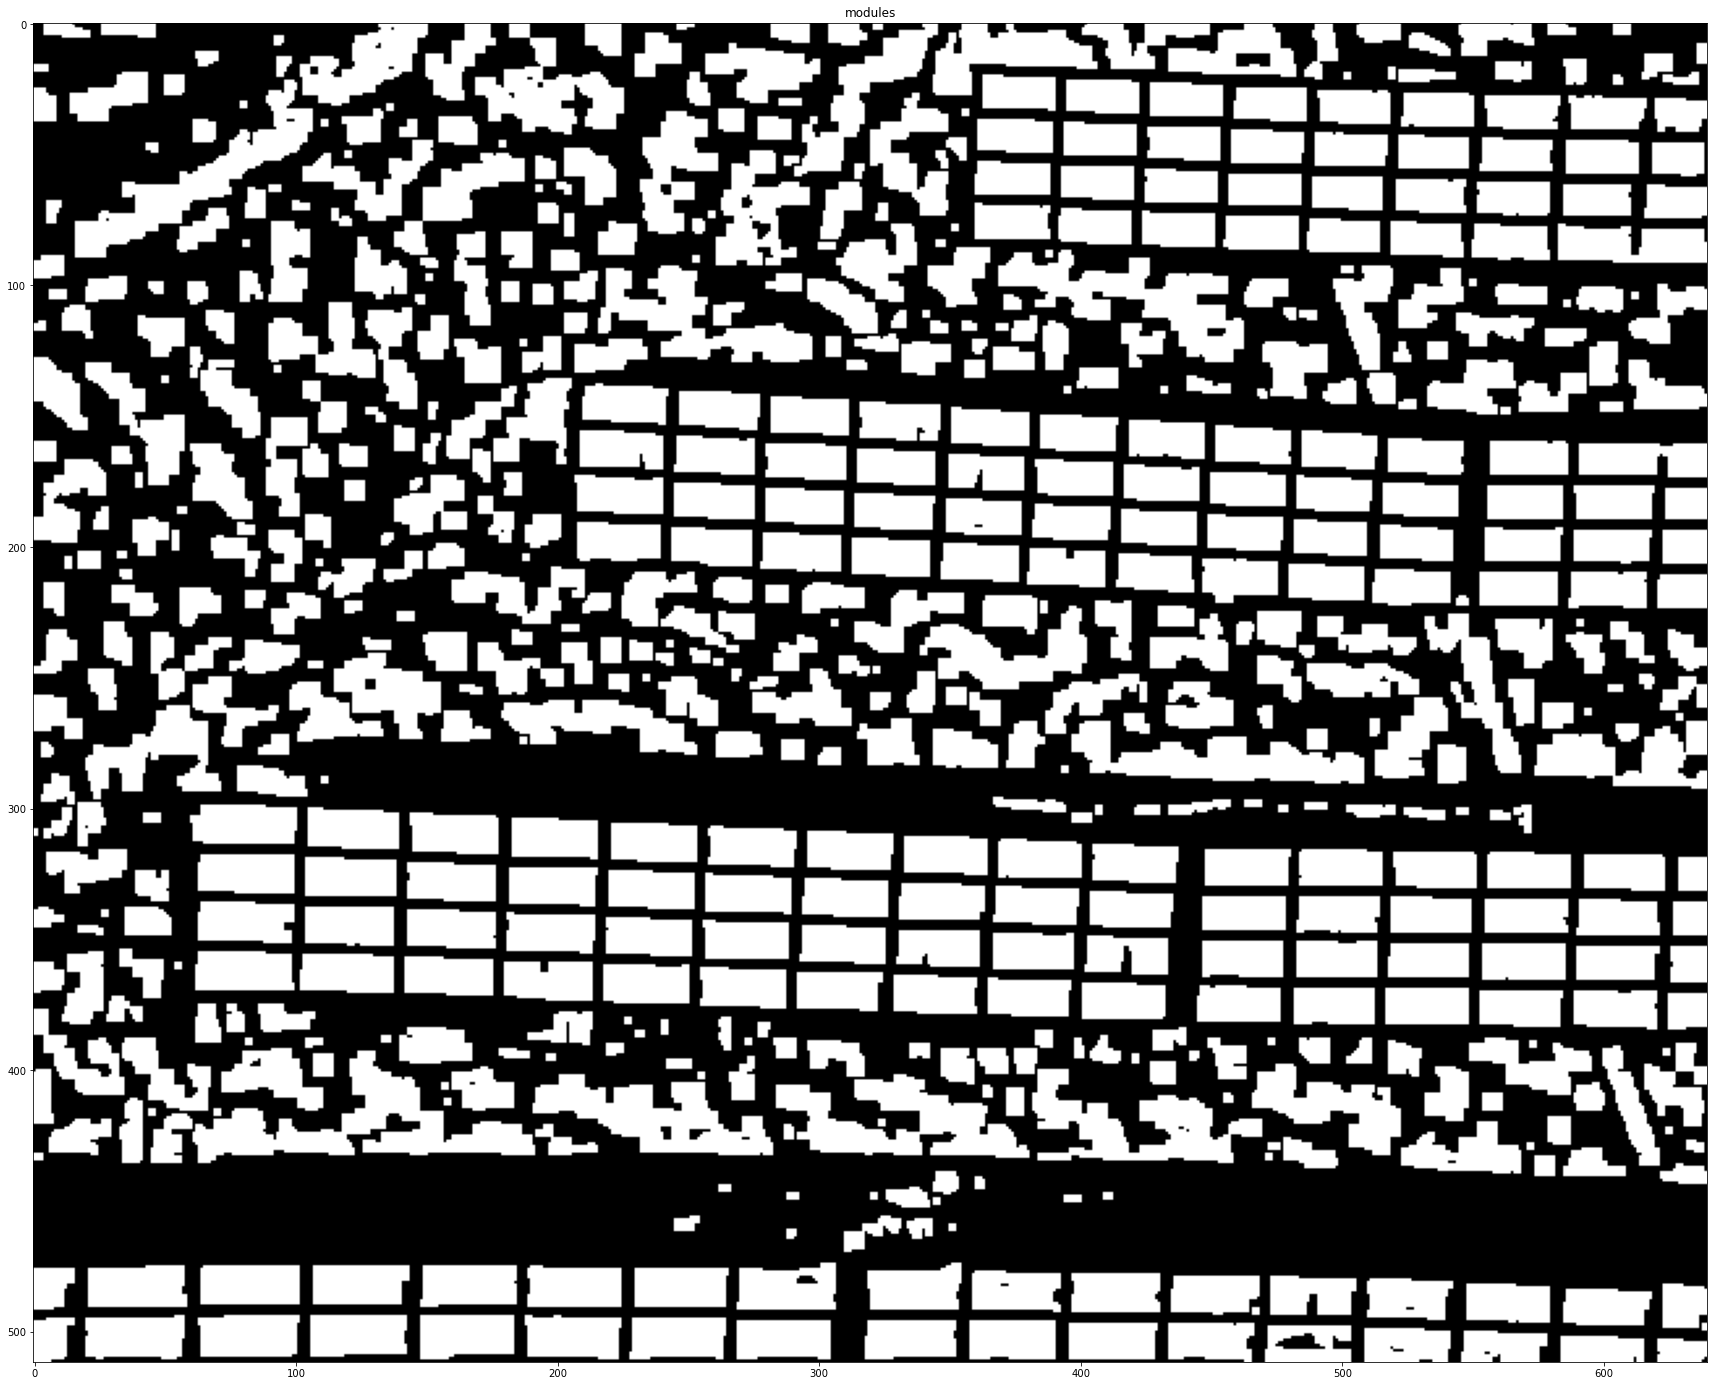

In [8]:
module_extraction.show_img({"modules":img_filtered},cmap="gray",figsize=(30,30))

（段階的な確認）

In [9]:
#img_normed = filters.normalize(img_org, show=True)

In [10]:
#img_clahe = filters.clahe(img_normed, show=True)

In [11]:
#img_blured = filters.blur(img_clahe, show=True)

In [12]:
#img_bilateral_filtered = filters.bilateral_filter(img_blured, show=True)

In [13]:
#img_sharpen = filters.sharpen(img_bilateral_filtered, show=True)

In [14]:
#img_opening = filters.opening(img_sharpen, show=True)

In [15]:
#img_eight_bit_scaled = filters.eight_bit_scaler(img_opening, show=True)

In [16]:
#img_averaged = filters.averaged_opening_data(img_eight_bit_scaled, show=True)

モジュール輪郭の検出

In [17]:
modules = Modules(img_filtered, anomaly_modules)

モジュール情報の表示

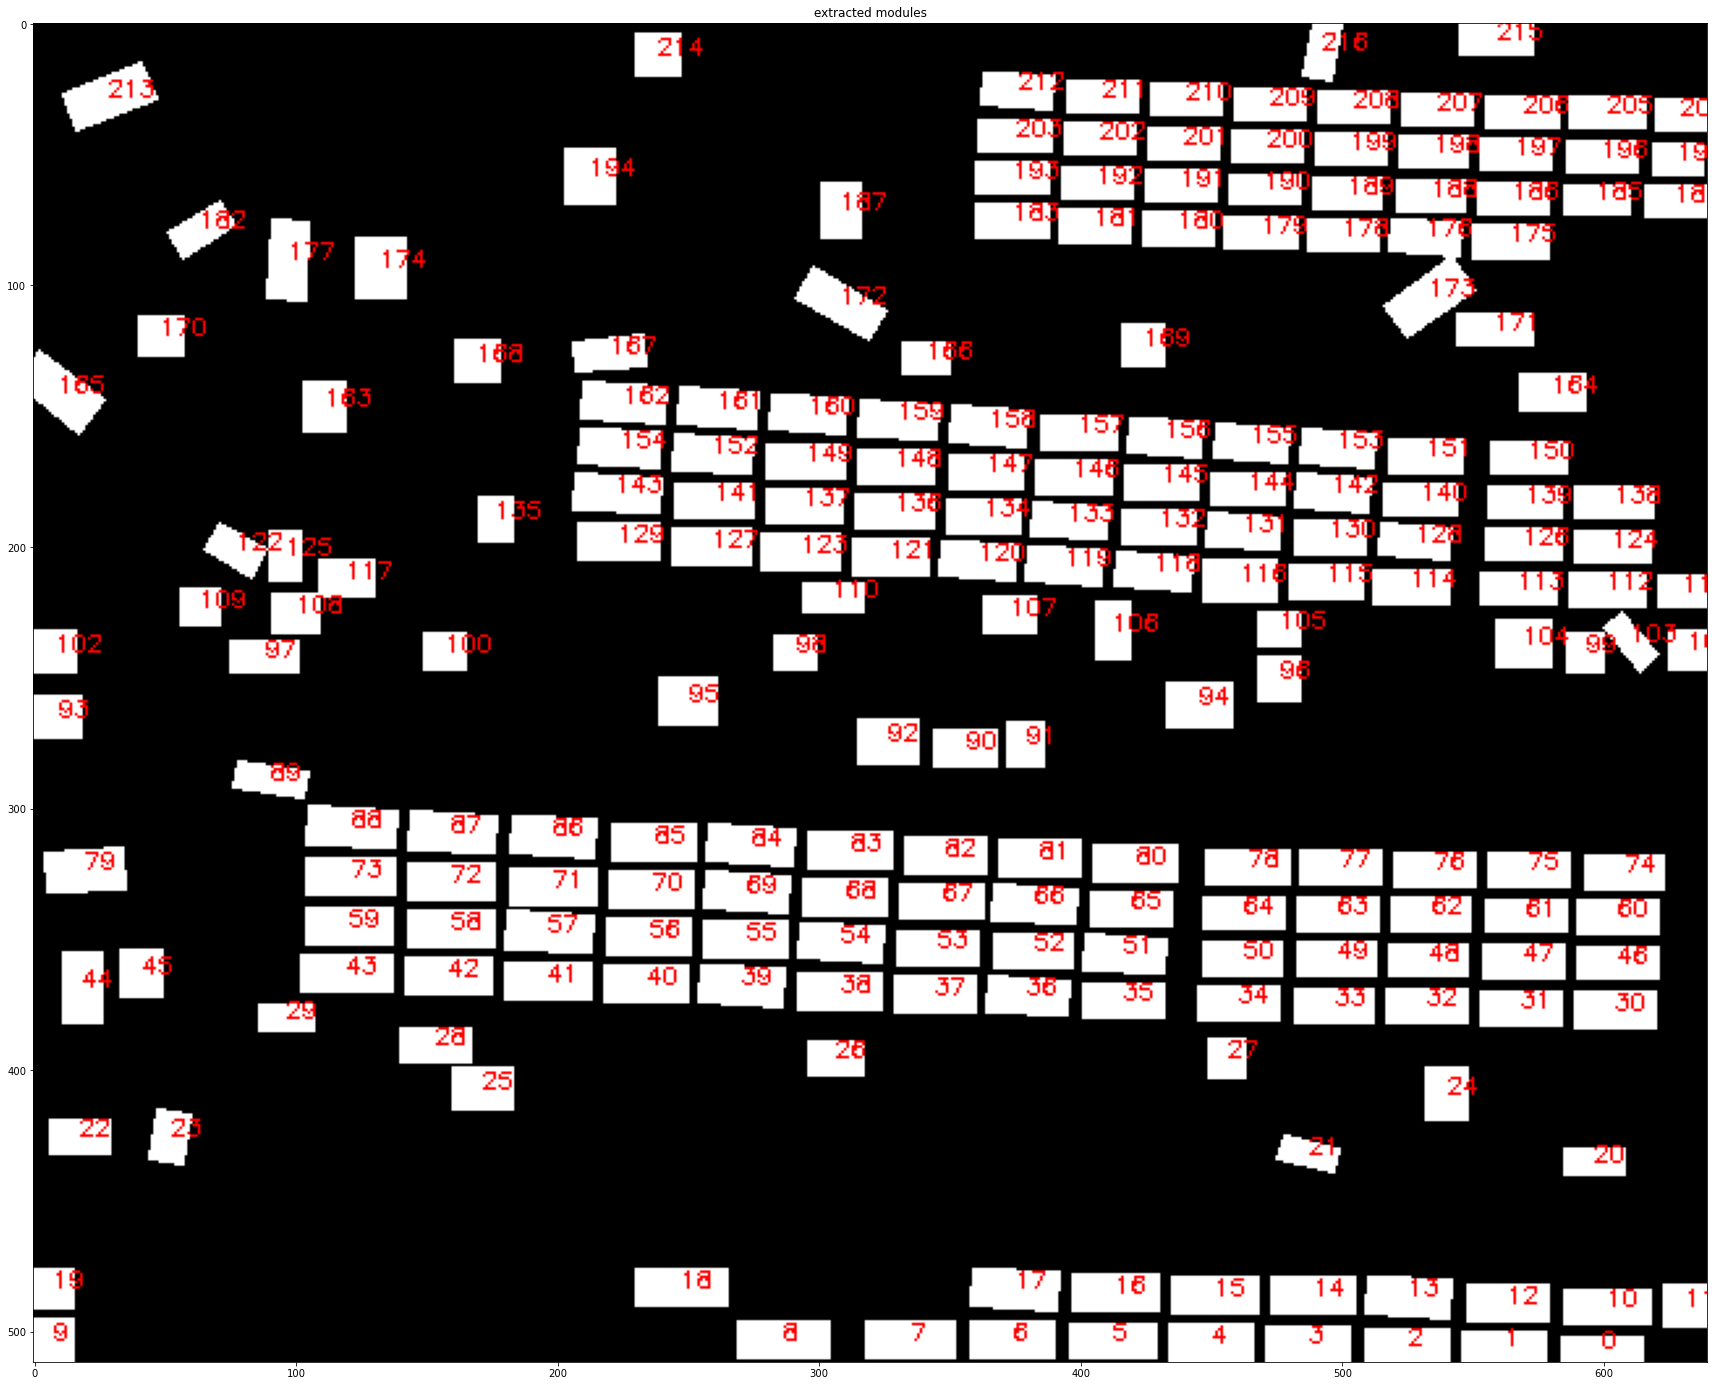

In [18]:
img_con_index = modules.get_img_contours(img_org, index=True)
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

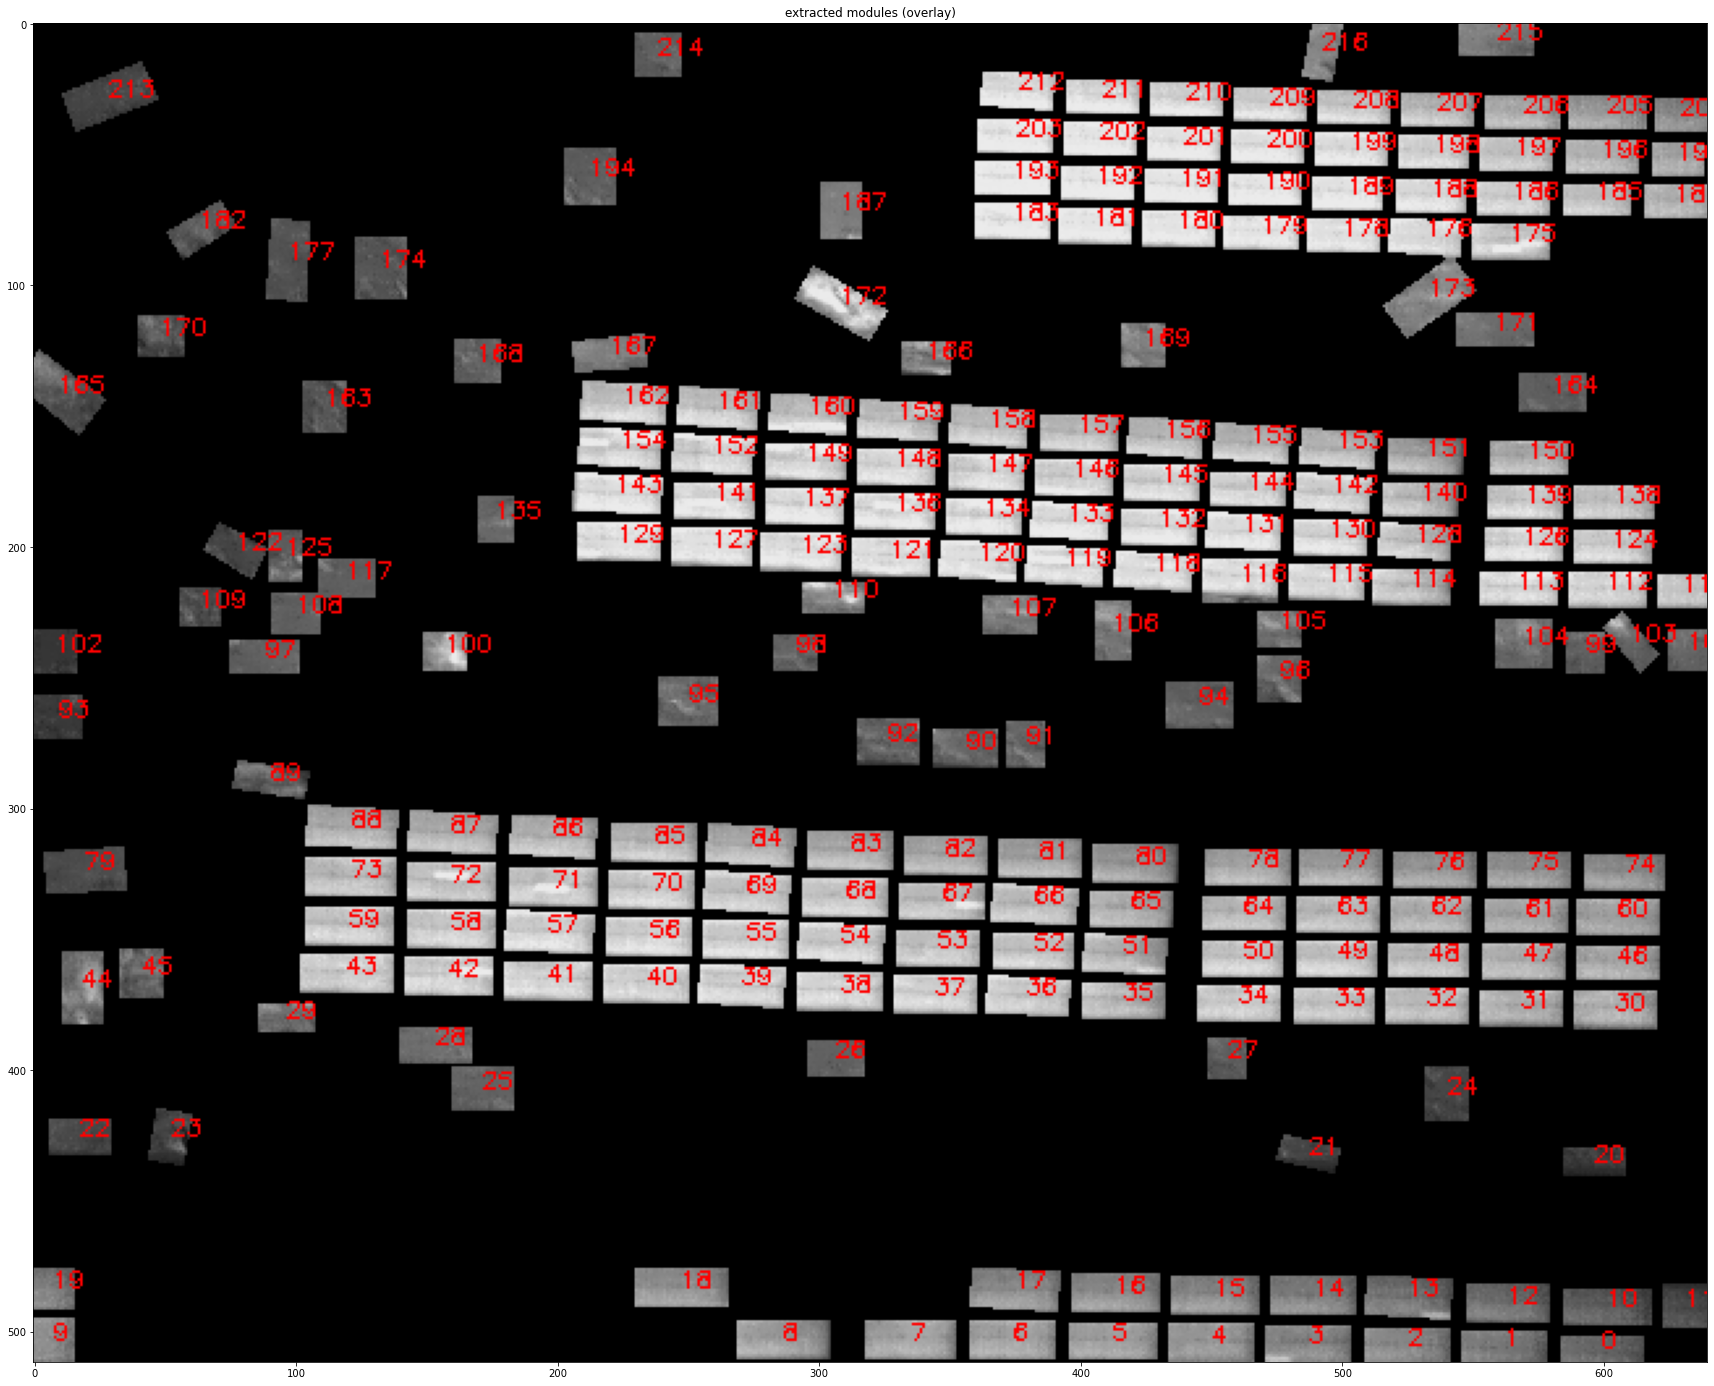

In [19]:
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"extracted modules (overlay)":img_mask_index},cmap="gray",figsize=(30,30))

ハイライトモジュールの表示

In [22]:
anomaly_contours = modules.get_anomaly_contours()
string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

/Users/tnozawa/afterFIT/work/rule_based_anomaly_detection/module_extraction.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


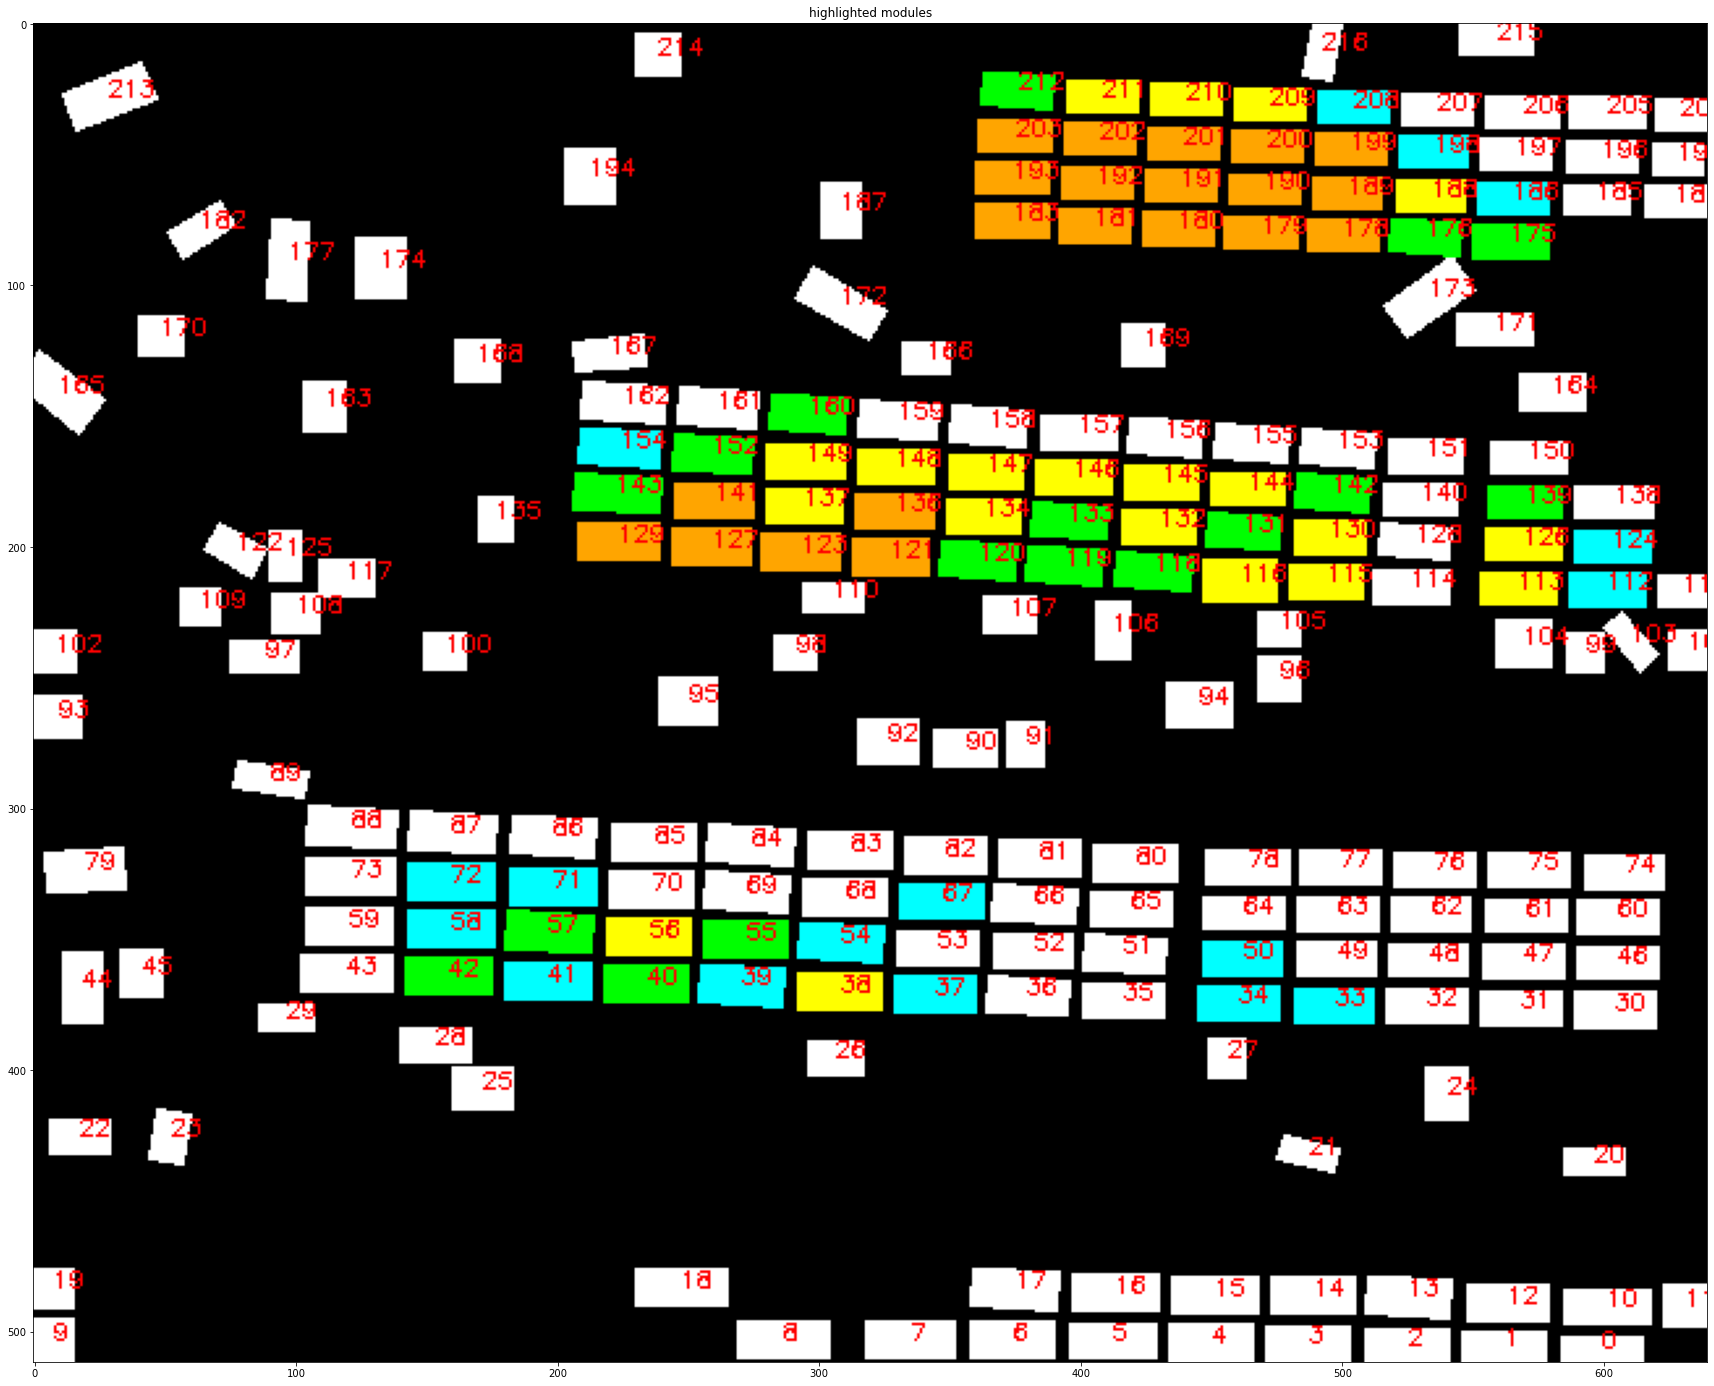

In [24]:
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
}
img_target_index = modules.get_img_contours(img_org, index=False)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [25]:
string_anomaly_labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

In [26]:
img_string_index = modules.get_img_target_contours(
    modules.get_img_contours(img_org, index=False),
    anomaly_contours["Module-Anomaly"][string_anomaly_labels>=0], 
    index=True, color=(238,130,238)) # violet

In [28]:
# クラスタリング可視化

In [29]:
import matplotlib.pyplot as plt

In [32]:
centers = np.array( [c.mean(axis=0) for c in anomaly_contours["Module-Anomaly"]] )
l = [ max(cv2.minAreaRect(c)[1]) for c in anomaly_contours["Module-Anomaly"]]
labels = modules.get_string_anomaly_labels(anomaly_contours["Module-Anomaly"])

(512.0, 0.0)

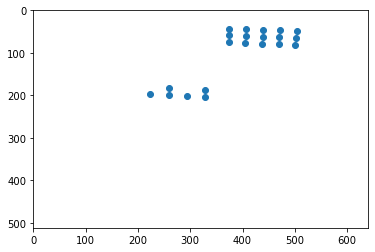

In [33]:
fig, ax = plt.subplots(facecolor="w")
plt.scatter(centers[:, 0], centers[:, 1])
ax.set_xlim([0, img_con.shape[1]])
ax.set_ylim([img_con.shape[0], 0])

In [38]:
scaled_centers = centers / np.mean(l)

(18.0, 0.0)

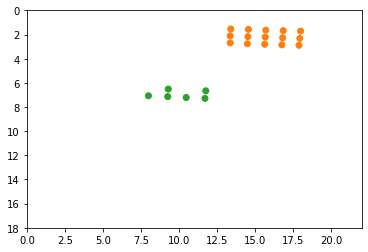

In [39]:
fig, ax = plt.subplots(facecolor="w")
cmap = plt.get_cmap("tab10")
plt.scatter(scaled_centers[:, 0], scaled_centers[:, 1], color=cmap(labels+1))
ax.set_xlim([0, int(img_con.shape[1] / np.mean(l))])
ax.set_ylim([int(img_con.shape[0] / np.mean(l)), 0])